Attention Layer with Contrastive Learning

In [1]:
from __future__ import absolute_import, division, print_function

import math
import os
import pickle
import numpy as np
import pandas

import scipy
import seaborn as sns

from time import time,sleep

import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Sampler

from pathlib import Path

import warnings
warnings.filterwarnings('ignore')

mypal = sns.color_palette('Set2')
emp_color = mypal[0]
pred_color = mypal[1]
print ("PyTorch version: " + torch.__version__)

import argparse


PyTorch version: 1.8.0


In [2]:
from data.utils import SimpleDataset, SimpleDataset_masked

from utils.metrics import NLL_reg, point_loss, get_CI_raw, pair_Ctd_DLN
from utils.trainer_helpers import batch_t_categorize, wt_avg, attention_mask


In [3]:
import argparse

parser = argparse.ArgumentParser(description='PyTorch ESSA Training')
parser.add_argument('--dataset', default='SEER', help='dataset setting')
parser.add_argument('-s',  default=16, type=int, help='embedding dimensions')
parser.add_argument('-nbin', default=100, type=int, help='discrete bins for time-to-event')

# parser.add_argument('--loss_type', default="MSE", type=str, help='point estimation loss type')
parser.add_argument('--loss_type',
                    default='MSE',
                    const='MSE',
                    nargs='?',
                    choices=['MSE', 'MAE', 'RAE'],
                    help='point estimation loss type (default: MSE)')

parser.add_argument('--percentile', default="True", type=str, help='time line discretize method')
parser.add_argument('--event_based', default="False", type=str, help='based on event timeline')
parser.add_argument('--num_try', default="0", type=str, help='number of try for the same architecture')

parser.add_argument('-enc_dim', nargs='+', type=int, default=[32,32],
                    help='encoder structure')
parser.add_argument('-dec_dim', nargs='+', type=int, default=[32,32],
                    help='decoder structure')

parser.add_argument('--emb_lr', default=1e-4, type=float,
                    metavar='EMBLR', help='learning rate for embedding network')
parser.add_argument('--clf_lr', default=1e-3, type=float,
                    metavar='CLFLR', help='learning rate for contrastive network')
parser.add_argument('--dec_lr', default=1e-4, type=float,
                    metavar='DECLR', help='learning rate for decoding network')

parser.add_argument('--ct_wt', default=1, type=float, help='weight for contrastive loss')
parser.add_argument('--pt_wt', default=0, type=float, help='weight for point estimation loss')

parser.add_argument('--epochs', default=200, type=int, metavar='N',
                    help='number of total epochs to run')
parser.add_argument('--continue_training', default='False', type=str,
                    help='continue training on the last best epoch')
parser.add_argument('-batch_size', default=128, type=int,
                    metavar='N',
                    help='mini-batch size')
parser.add_argument('--momentum', default=0.9, type=float, metavar='M',
                    help='momentum')
parser.add_argument('--wd', '--weight-decay', default=2e-4, type=float,
                    metavar='W', help='weight decay (default: 1e-4)',
                    dest='weight_decay')
parser.add_argument('-p', '--print-freq', default=100, type=int,
                    metavar='N', help='print frequency (default: 100)')

parser.add_argument('--result_path_root', '--wording-dir',default='', type=str, metavar='PATH',
                    help='path to the result files')
parser.add_argument('--file_path',default='', type=str, metavar='FILEPATH',
                    help='path to the data files')
parser.add_argument('-e', '--evaluate', dest='evaluate', action='store_true',
                    help='evaluate model on validation set')

parser.add_argument('--seed', default=None, type=int,
                    help='seed for initializing training. ')

parser.add_argument('--gpu', default=0, type=int,
                    help='GPU id to use.')

# to run argparse without command line
import sys
sys.argv = ['']

global args
args = parser.parse_args()


In [4]:
args

Namespace(batch_size=128, clf_lr=0.001, continue_training='False', ct_wt=1, dataset='SEER', dec_dim=[32, 32], dec_lr=0.0001, emb_lr=0.0001, enc_dim=[32, 32], epochs=200, evaluate=False, event_based='False', file_path='', gpu=0, loss_type='MSE', momentum=0.9, nbin=100, num_try='0', percentile='True', print_freq=100, pt_wt=0, result_path_root='', s=16, seed=None, weight_decay=0.0002)

In [5]:
result_path_root = '/data/zidi/ACSurv/results/SEER'
file_path='/data/zidi/cVAE/datasets/'

args.result_path_root = result_path_root
args.file_path = file_path
args.model_name = 'ELSSA'

In [6]:
event_based = 'event' if args.event_based == 'True' else 'all'
percentile = 'percentile' if args.percentile == 'True' else 'linespace'

args.store_name = '_'.join([args.model_name, args.dataset,\
                            event_based,percentile, 'nbin', str(args.nbin),\
                            'emb', str(args.s),\
                            'enc', '_'.join([str(dim) for dim in args.enc_dim]),\
                            'dec', '_'.join([str(dim) for dim in args.dec_dim]),\
                           'ctWt', str(args.ct_wt), 'ptWt', str(args.pt_wt), args.num_try])



args.store_name

'ELSSA_SEER_all_percentile_nbin_100_emb_16_enc_32_32_dec_32_32_ctWt_1_ptWt_0_0'

## SEER Dataset

Load flchain dataset

In [7]:
from data.seer_data import generate_data

train, valid, test, variable_info = generate_data(data_path = args.file_path, m=args.s)
train_size = train['x'].shape[0]
val_size = valid['x'].shape[0]

dropped_columns:51
size_categorical:61
data_path:/data/zidi/cVAE/datasets/
all_data:(798624, 132)
cohort_year:[1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005
 2006 2007]
cohort data:(360921, 132)
observed 10 year cohort:(174816, 132)
only active follow up data:(174816, 132)
observed survival time:(141382, 132)
Known survival time (141382, 132)
Removed dublicate patients:(94019, 132)
Known ER status data:(77322, 132)
Known PR status  data:(76130, 132)
Microscopically confirmed data:(76122, 132)
age greater than 20: (76118, 132)
age is known: (76117, 132)
Female only: (75548, 132)
Reliable reporting source: (75548, 132)
Removed unstaged: (75015, 132)
Removed ungraded: (68082, 132)
cancer_deaths:0.2655255423786386, cvd_deaths:0.07647206510020528, all_deaths:0.5084550516164287,  other_deaths:0.16645744413758473
head of data:           REG  MAR_STAT  RACE1V  NHIADE  SEX  AGE_DX  YR_BRTH  SEQ_NUM  \
PUBCSNUM                                                              

end_time:120
observed percent:0.5084550516164287
shuffled x:[6.0e+00 1.0e+00 0.0e+00 0.0e+00 5.4e+01 1.0e+01 1.3e+01 4.0e+00 0.0e+00
 8.5e+03 2.0e+00 8.5e+03 1.0e+00 1.0e+00 0.0e+00 0.0e+00 2.4e+01 1.1e+01
 2.0e+00 3.0e+00 1.0e+01 0.0e+00 0.0e+00 1.9e+01 1.0e+02 2.5e+02 0.0e+00
 0.0e+00 0.0e+00 3.0e+00 4.0e+00 3.0e+00 2.0e+00 5.0e+00 6.0e+00 0.0e+00
 2.0e+00 3.0e+00 3.0e+00 5.0e+00 0.0e+00 5.0e+00 0.0e+00 9.0e+00 0.0e+00
 1.2e+01 0.0e+00 6.0e+00 4.0e+00 5.0e+00 2.0e+00 5.0e+00 1.0e+00 6.0e+00
 0.0e+00 0.0e+00 0.0e+00 2.0e+00 1.0e+00 1.0e+00 1.0e+00 1.0e+00 1.0e+00
 0.0e+00 2.0e+00 3.0e+00 3.0e+00 3.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00
 2.0e+00 5.0e+00 1.0e+00 0.0e+00 2.0e+00 2.0e+01 1.2e+01 0.0e+00 0.0e+00], t:109, e:0, len:67711
test:20313, valid:6772, train:40626, all: 67711
observed fold:0.5067444493674002
cancer:(40626,), cvd:(40626,), other:(40626,)
observed fold:0.5112489538719047
cancer:(20313,), cvd:(20313,), other:(20313,)
observed fold:0.5103366804489072
cancer:(6772,), cvd:

In [8]:
cov_list, cts_var, cts_idx, cat_var, cat_idx = variable_info['cov_list'], variable_info['cts_var'], variable_info['cts_idx'], variable_info['cat_var'], variable_info['cat_idx']
x_landmarks, x_levels = variable_info['x_landmarks'], variable_info['x_levels']

In [9]:
if args.event_based == 'True':
    train_time = train['t'][train['e']==1]
else:
    train_time = train['t']


if args.percentile == 'True':
    '''based on each covariate percentile'''
    t_landmarks = torch.tensor(np.percentile(train_time, np.linspace(0,100,args.s))).contiguous()
    tt = np.percentile(train_time,np.linspace(0.,100.,args.nbin, endpoint=True))

else:
    '''based on the each covariate range'''
    t_landmarks = torch.tensor(np.linspace(np.min(train_time),np.max(train_time),args.s, endpoint=True)).contiguous()
    tt = np.linspace(np.min(train_time),np.max(train_time),args.nbin, endpoint=True)


# based on whether we have censoring after the largest observed t
loss_of_info = np.mean(train['t']>np.max(train['t'][train['e']==1]))

# need to convert t to different size of bins
if loss_of_info > 0.0001:
    args.nbin = args.nbin + 1
    # add the largest observed censoring time inside
    tt = np.append(tt,np.max(train['t']))
#     event_tt_prob = risk_t_bin_prob(train['t'], train['e'], tt)

t_max = np.max(train['t'][train['e']==1])
t_all_max = np.max(train['t'])
t_all_max, t_max, loss_of_info

(120.0, 120.0, 0.0)

100

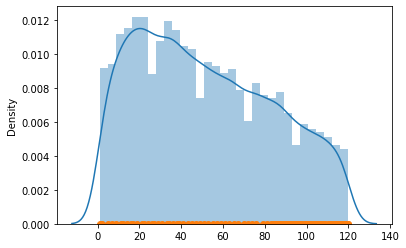

In [10]:
sns.distplot(train['t'][train['e']==1])
plt.plot(tt, np.zeros(len(tt)),'o')
len(tt)

### Embedding the covariates into $\mathbb{R}^m$
- for each continuous variable, first find $m$ landmarkers, then interpolate values in between
- for each categorical variable, find the matched embedding vector with $m$ dimensions

Define landmarkers for each continuous variable### Embedding the covariates into $\mathbb{R}^m$

In [11]:
from model.embedding import Embedding
from model.attention import Attention, SelfAttention
from model.ContrastiveLearning import FDV_CL
from model.SimpleNN import *



In [12]:
ncov = train['x'].shape[1]
covList = np.arange(ncov)

trainData = SimpleDataset_masked(train['x'], train['t'], train['e'], train['missing_mask'])
pair1 = DataLoader(trainData, batch_size=args.batch_size,shuffle=True)

validData = SimpleDataset_masked(valid['x'], valid['t'], valid['e'], valid['missing_mask'])
v_pair1 = DataLoader(validData, batch_size=args.batch_size,shuffle=True)
# v_pair2 = DataLoader(validData, batch_size=500,shuffle=True)

testData = SimpleDataset_masked(test['x'], test['t'], test['e'], test['missing_mask'])
t_pair1 = DataLoader(testData, batch_size=args.batch_size,shuffle=True)


In [13]:
args.continue_training = 'True'
result_path_root


'/data/zidi/ACSurv/results/SEER'

In [14]:
zdim = args.s
epochs = args.epochs
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device_name = args.gpu
n_gpu = torch.cuda.device_count()
all_device = set(np.arange(torch.cuda.device_count()))
all_device.remove(args.gpu)
device_ids = [args.gpu] + list(all_device)

torch.cuda.set_device(device_name)

# point estimation loss function and weight
# loss_type = args.loss_type
# lambda_ = args.pt_wt
# ctr_wt = args.ct_wt
# bined time
tt = torch.tensor(tt).to(device)

result_path = args.result_path_root+'/saved_models/'
Path(result_path).mkdir(parents=True, exist_ok=True)

pickle.dump( args, open( result_path+args.store_name+"_args.pkl", "wb" ) )

'''covariate embedding'''
embedding = Embedding(ncov, cts_var, cts_idx, cat_var, cat_idx, x_landmarks, x_levels, m=args.s)

'''attention network'''
# attention = LinearAtt(ncov=ncov, dropout=0.1)
# attention = Attention(dropout=0.1)
attention = SelfAttention(dropout=0.1)
'''contrastive learning'''
# input is pair of latent Z
clf = FDV_CL(m = args.s, ncov = ncov, t_landmarks = t_landmarks, h_dim=args.enc_dim)


'''decoding the embedded vectors'''
decoder = DecMLP_bin(input_size = zdim, output_size = args.nbin, h_dim=args.dec_dim)

emb_path = result_path+args.store_name+'_emb'+'.pt'
dec_path = result_path+args.store_name+'_dec'+'.pt'
att_path = result_path+args.store_name+'_att'+'.pt'
clf_path = result_path+args.store_name+'_clf'+'.pt'


if args.continue_training == 'True':
    embedding.load_state_dict(torch.load(emb_path))
    attention.load_state_dict(torch.load(att_path))
    clf.load_state_dict(torch.load(clf_path))
    decoder.load_state_dict(torch.load(dec_path))


# put models on device 0
embedding.to(device)
clf.to(device)
attention.to(device)
decoder.to(device)

# define optimizer
opt_emb = optim.Adam(embedding.parameters(), lr=args.emb_lr)
opt_dec = optim.Adam(decoder.parameters(), lr=args.dec_lr)
opt_clf = optim.Adam(clf.parameters(), lr=args.clf_lr)

# define scheduler
emb_scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt_emb, mode='min', factor=0.1, patience=5, min_lr=0, verbose=True)
dec_scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt_dec, mode='min', factor=0.1, patience=5, min_lr=0, verbose=True)
clf_scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt_clf, mode='min', factor=0.1, patience=5, min_lr=0, verbose=True)

# opt_emb = torch.optim.SGD(embedding.parameters(), args.emb_lr,
#                                 momentum=args.momentum,
#                                 weight_decay=args.weight_decay)

# opt_dec = torch.optim.SGD(decoder.parameters(), args.dec_lr,
#                                 momentum=args.momentum,
#                                 weight_decay=args.weight_decay)

# only the training of decoder is suitable for parallelization
decoder = nn.DataParallel(decoder, device_ids=device_ids)
attention = nn.DataParallel(attention, device_ids=device_ids)
clf = nn.DataParallel(clf, device_ids=device_ids)


# opt_att = optim.Adam(attention.parameters(), lr=1e-4)



# att_path = result_path+model_name+'_att.pt'
print(embedding, attention, clf, decoder)

Embedding(
  (x_emb_landmarks): ParameterDict(
      (AGE_DX): Parameter containing: [torch.cuda.FloatTensor of size 16x16 (GPU 0)]
      (HISTO2V): Parameter containing: [torch.cuda.FloatTensor of size 16x16 (GPU 0)]
      (HISTO3V): Parameter containing: [torch.cuda.FloatTensor of size 16x16 (GPU 0)]
      (EOD10_SZ): Parameter containing: [torch.cuda.FloatTensor of size 16x16 (GPU 0)]
      (EOD10_EX): Parameter containing: [torch.cuda.FloatTensor of size 16x16 (GPU 0)]
      (EOD10_ND): Parameter containing: [torch.cuda.FloatTensor of size 16x16 (GPU 0)]
      (EOD10_PN): Parameter containing: [torch.cuda.FloatTensor of size 16x16 (GPU 0)]
      (EOD10_NE): Parameter containing: [torch.cuda.FloatTensor of size 16x16 (GPU 0)]
      (CSTUMSIZ): Parameter containing: [torch.cuda.FloatTensor of size 16x16 (GPU 0)]
      (CSEXTEN): Parameter containing: [torch.cuda.FloatTensor of size 16x16 (GPU 0)]
      (CSLYMPHN): Parameter containing: [torch.cuda.FloatTensor of size 16x16 (GPU 0)]
 

epoch1


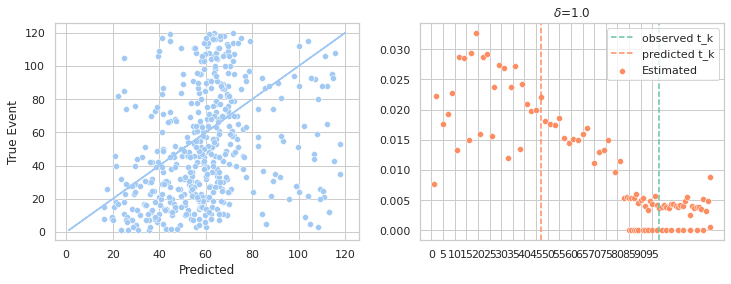

====> Train NLL: 2.328 	 Valid NLL: 2.330 CI: 0.826 event loss: 615.022 	 censoring loss : 68.831 	 Improved: *
epoch2


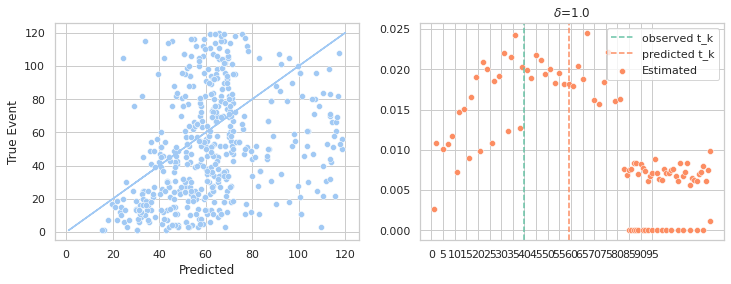

====> Train NLL: 2.329 	 Valid NLL: 2.329 CI: 0.827 event loss: 611.551 	 censoring loss : 69.565 	 Improved: *
epoch3
====> Train NLL: 2.327 	 Valid NLL: 2.336 CI: 0.826 event loss: 601.141 	 censoring loss : 74.976 	 Improved:  
epoch4
====> Train NLL: 2.328 	 Valid NLL: 2.328 CI: 0.826 event loss: 625.726 	 censoring loss : 63.121 	 Improved:  
epoch5
====> Train NLL: 2.326 	 Valid NLL: 2.333 CI: 0.826 event loss: 606.185 	 censoring loss : 71.859 	 Improved:  
epoch6
====> Train NLL: 2.327 	 Valid NLL: 2.328 CI: 0.826 event loss: 615.670 	 censoring loss : 68.021 	 Improved:  
epoch7


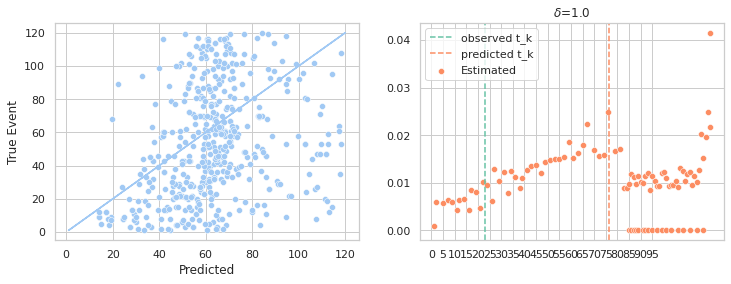

====> Train NLL: 2.325 	 Valid NLL: 2.328 CI: 0.827 event loss: 625.850 	 censoring loss : 63.312 	 Improved: *
epoch8
====> Train NLL: 2.323 	 Valid NLL: 2.331 CI: 0.827 event loss: 610.749 	 censoring loss : 69.758 	 Improved:  
epoch9
Epoch     9: reducing learning rate of group 0 to 1.0000e-05.


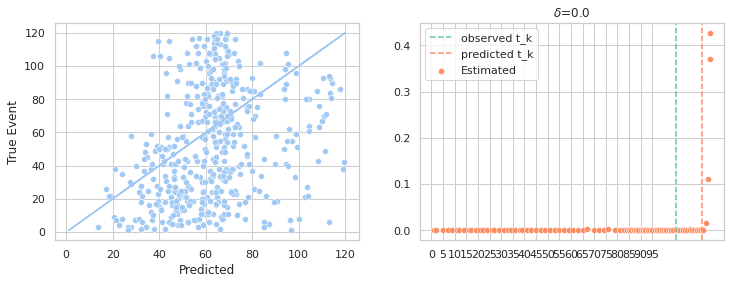

====> Train NLL: 2.326 	 Valid NLL: 2.330 CI: 0.827 event loss: 614.503 	 censoring loss : 67.724 	 Improved: *
epoch10
====> Train NLL: 2.325 	 Valid NLL: 2.327 CI: 0.827 event loss: 628.268 	 censoring loss : 62.122 	 Improved:  
epoch11


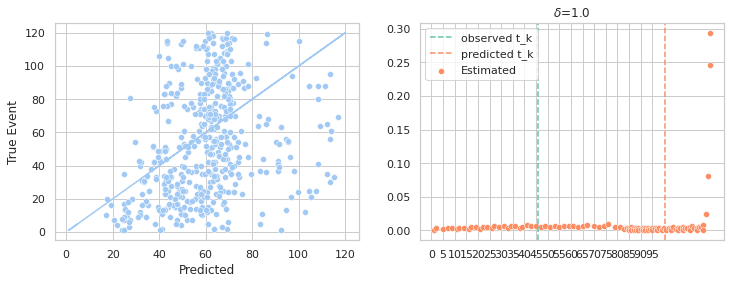

====> Train NLL: 2.323 	 Valid NLL: 2.329 CI: 0.827 event loss: 609.682 	 censoring loss : 70.871 	 Improved: *
epoch12


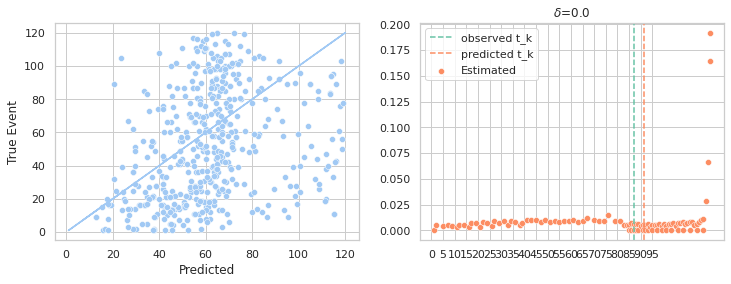

====> Train NLL: 2.323 	 Valid NLL: 2.325 CI: 0.827 event loss: 621.175 	 censoring loss : 64.055 	 Improved: *
epoch13


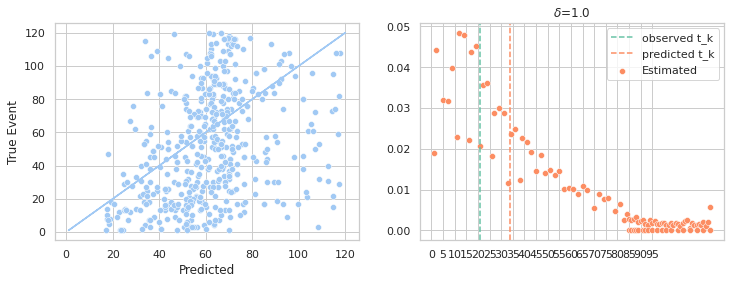

====> Train NLL: 2.324 	 Valid NLL: 2.327 CI: 0.827 event loss: 618.324 	 censoring loss : 65.550 	 Improved: *
epoch14


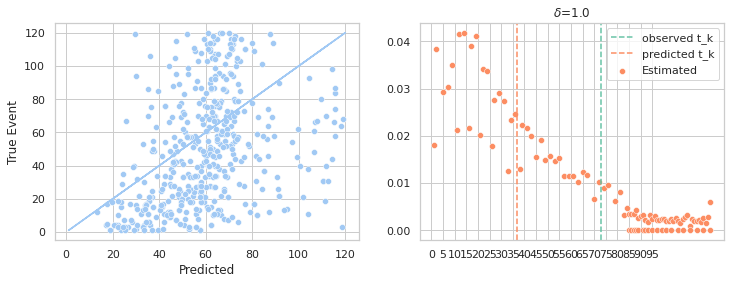

====> Train NLL: 2.322 	 Valid NLL: 2.324 CI: 0.827 event loss: 625.603 	 censoring loss : 62.070 	 Improved: *
epoch15
Epoch    15: reducing learning rate of group 0 to 1.0000e-06.
====> Train NLL: 2.322 	 Valid NLL: 2.326 CI: 0.827 event loss: 627.836 	 censoring loss : 61.104 	 Improved:  
epoch16
====> Train NLL: 2.324 	 Valid NLL: 2.331 CI: 0.827 event loss: 603.429 	 censoring loss : 73.725 	 Improved:  
epoch17


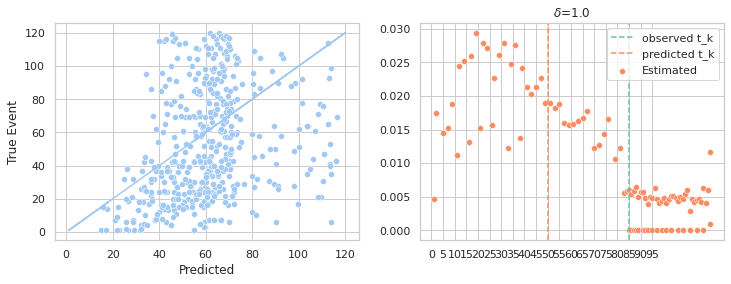

====> Train NLL: 2.322 	 Valid NLL: 2.326 CI: 0.827 event loss: 619.228 	 censoring loss : 65.150 	 Improved: *
epoch18


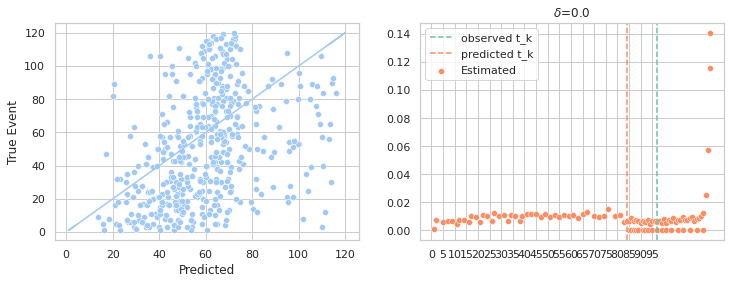

====> Train NLL: 2.320 	 Valid NLL: 2.328 CI: 0.827 event loss: 607.730 	 censoring loss : 69.982 	 Improved: *
epoch19
====> Train NLL: 2.319 	 Valid NLL: 2.330 CI: 0.827 event loss: 599.916 	 censoring loss : 74.859 	 Improved:  
epoch20
Epoch    20: reducing learning rate of group 0 to 1.0000e-05.
====> Train NLL: 2.321 	 Valid NLL: 2.326 CI: 0.827 event loss: 613.558 	 censoring loss : 66.779 	 Improved:  
epoch21


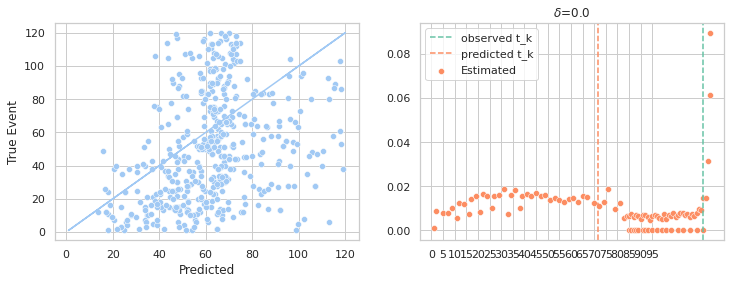

====> Train NLL: 2.321 	 Valid NLL: 2.328 CI: 0.827 event loss: 614.818 	 censoring loss : 66.860 	 Improved: *
epoch22
====> Train NLL: 2.320 	 Valid NLL: 2.332 CI: 0.827 event loss: 599.451 	 censoring loss : 75.666 	 Improved:  
epoch23


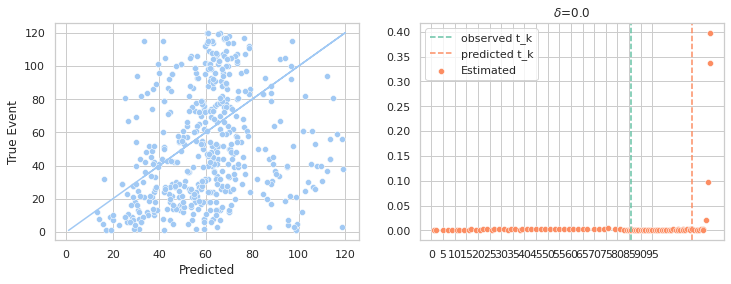

====> Train NLL: 2.320 	 Valid NLL: 2.327 CI: 0.827 event loss: 605.721 	 censoring loss : 71.293 	 Improved: *
epoch24
====> Train NLL: 2.321 	 Valid NLL: 2.325 CI: 0.827 event loss: 617.594 	 censoring loss : 65.238 	 Improved:  
epoch25


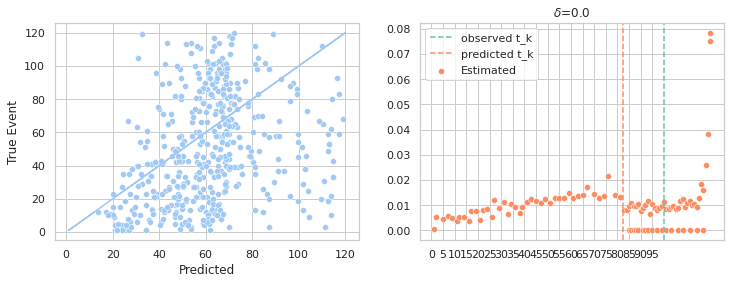

====> Train NLL: 2.321 	 Valid NLL: 2.327 CI: 0.827 event loss: 623.281 	 censoring loss : 62.898 	 Improved: *
epoch26
Epoch    26: reducing learning rate of group 0 to 1.0000e-06.
====> Train NLL: 2.320 	 Valid NLL: 2.324 CI: 0.827 event loss: 634.734 	 censoring loss : 58.149 	 Improved:  
epoch27


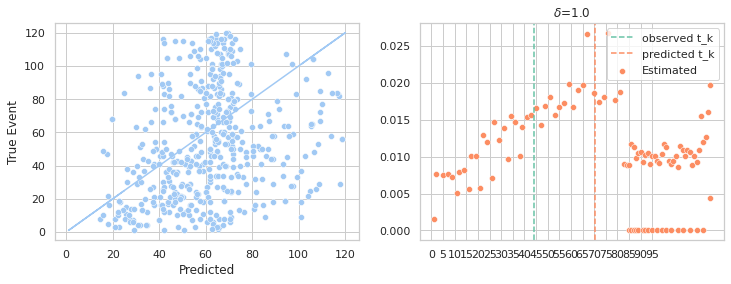

====> Train NLL: 2.321 	 Valid NLL: 2.325 CI: 0.827 event loss: 615.472 	 censoring loss : 66.177 	 Improved: *
epoch28
Epoch    28: reducing learning rate of group 0 to 1.0000e-07.
====> Train NLL: 2.319 	 Valid NLL: 2.330 CI: 0.827 event loss: 602.337 	 censoring loss : 73.089 	 Improved:  
epoch29
====> Train NLL: 2.322 	 Valid NLL: 2.327 CI: 0.827 event loss: 609.008 	 censoring loss : 69.810 	 Improved:  
epoch30
Epoch    30: reducing learning rate of group 0 to 1.0000e-05.
====> Train NLL: 2.321 	 Valid NLL: 2.328 CI: 0.827 event loss: 600.438 	 censoring loss : 74.148 	 Improved:  
epoch31
====> Train NLL: 2.318 	 Valid NLL: 2.326 CI: 0.827 event loss: 613.271 	 censoring loss : 67.281 	 Improved:  
epoch32
Epoch    32: reducing learning rate of group 0 to 1.0000e-07.
====> Train NLL: 2.319 	 Valid NLL: 2.326 CI: 0.827 event loss: 609.790 	 censoring loss : 69.316 	 Improved:  
epoch33


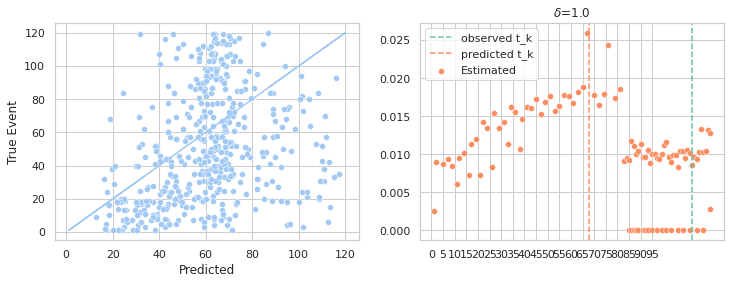

====> Train NLL: 2.321 	 Valid NLL: 2.326 CI: 0.827 event loss: 610.020 	 censoring loss : 68.876 	 Improved: *
epoch34
Epoch    34: reducing learning rate of group 0 to 1.0000e-08.
====> Train NLL: 2.319 	 Valid NLL: 2.326 CI: 0.827 event loss: 613.502 	 censoring loss : 67.732 	 Improved:  
epoch35
====> Train NLL: 2.320 	 Valid NLL: 2.327 CI: 0.827 event loss: 609.762 	 censoring loss : 69.095 	 Improved:  
epoch36


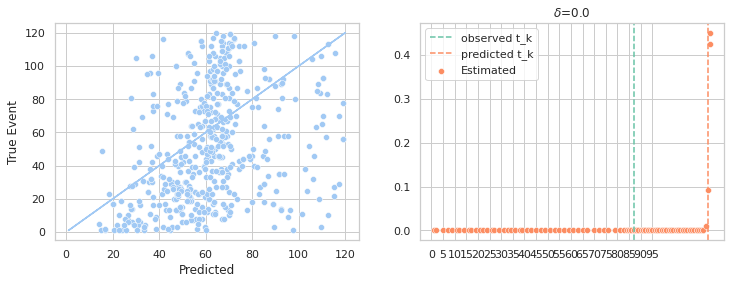

====> Train NLL: 2.319 	 Valid NLL: 2.325 CI: 0.827 event loss: 612.848 	 censoring loss : 66.854 	 Improved: *
epoch37
====> Train NLL: 2.321 	 Valid NLL: 2.326 CI: 0.827 event loss: 609.915 	 censoring loss : 68.649 	 Improved:  
epoch38
Epoch    38: reducing learning rate of group 0 to 1.0000e-08.
Epoch    38: reducing learning rate of group 0 to 1.0000e-06.
====> Train NLL: 2.320 	 Valid NLL: 2.326 CI: 0.827 event loss: 614.074 	 censoring loss : 67.183 	 Improved:  
epoch39
====> Train NLL: 2.319 	 Valid NLL: 2.326 CI: 0.827 event loss: 614.967 	 censoring loss : 67.465 	 Improved:  
epoch40
====> Train NLL: 2.321 	 Valid NLL: 2.326 CI: 0.827 event loss: 614.199 	 censoring loss : 67.262 	 Improved:  
epoch41
====> Train NLL: 2.317 	 Valid NLL: 2.326 CI: 0.827 event loss: 614.395 	 censoring loss : 66.814 	 Improved:  
epoch42
====> Train NLL: 2.318 	 Valid NLL: 2.326 CI: 0.827 event loss: 613.926 	 censoring loss : 67.243 	 Improved:  
epoch43
====> Train NLL: 2.321 	 Valid NLL: 

KeyboardInterrupt: 

In [37]:
best_valid_e_loss = np.inf
best_valid_NLL_loss = np.inf
best_valid_CI = 0
best_epoch = 0

train_loss_hist = []
train_loss_NLL_hist = []
train_loss_est_hist = []
train_lost_ctr_hist = []

valid_loss_hist = []
valid_loss_NLL_hist = []
valid_loss_est_hist = []
valid_lost_ctr_hist = []

for epoch in range(1, epochs + 1):


    train_loss = 0
    train_ctr_loss = 0
    train_NLL_loss, train_est_loss = 0, 0
    
    valid_e_loss = 0
    valid_c_loss = 0
    valid_NLL_loss, valid_est_loss = 0, 0

    print('epoch'+str(epoch))
    improved_str = " "
    embedding.train()
    clf.train()
    decoder.train()


    for i, (x, y, e, mask) in enumerate(pair1):
#         print(i)
        # training encoder and decoder
        
        x= x.to(device).float()
        y = y.to(device).float()
        e = e.to(device)
            
        x_emb, var_list = embedding(x)
        
        # re-indexing mask
        # when certain observation is missed, the corresponding mask is 0
        reindex = torch.tensor([np.where(cov_list==var)[0][0] for var in var_list])
        mask_new = torch.index_select(mask, 1, reindex)
        del mask
        mask_attn = attention_mask(mask_new, ncov, p=0.1) 
        z, attn_score = attention(x_emb, mask = mask_attn)
        del mask_attn
        loss_infoNCE = clf(z, y, e).mean()
        
        p_raw = decoder(clf.module.enc(z))
        
        loss_NLL = NLL_reg(p_raw, y, e, tt)
        
        # weighted average
        t_wa_hat = wt_avg(p_raw, tt)
        
        eloss, closs = point_loss(t_wa_hat, y, e, args.loss_type)
        loss_est = (closs + eloss)/len(e)
    
        surv_loss = loss_NLL + args.pt_wt*loss_est

        # update parameters
        loss = surv_loss + args.ct_wt*loss_infoNCE
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(embedding.parameters(), 1e-1)
        torch.nn.utils.clip_grad_norm_(decoder.parameters(), 1e-1)
        torch.nn.utils.clip_grad_norm_(clf.parameters(), 1e-1)
        
        train_loss += surv_loss.item()
        train_NLL_loss += loss_NLL.item()
        train_est_loss += loss_est.item()
        train_ctr_loss += loss_infoNCE.item()
        
        opt_emb.step()
        opt_clf.step()
        opt_dec.step()  
        

    
    embedding.eval()
    attention.eval()
    decoder.eval()
    clf.eval()
    
    valid_e_loss = 0
    valid_c_loss = 0
    valid_ct_loss = 0
    valid_pred_t, valid_e, valid_t = [],[],[]

    for i, (x, y, e, mask) in enumerate(v_pair1):
        x= x.to(device).float()
        y = y.to(device).float()
        e = e.to(device)
        
        x_emb, var_list = embedding(x)
        
        # re-indexing mask
        reindex = torch.tensor([np.where(cov_list==var)[0][0] for var in var_list])
        mask_new = torch.index_select(mask, 1, reindex)
        del mask
        mask_attn = attention_mask(mask_new, ncov, p=0.1) 
        
        del mask_new
        z, attn_score = attention(x_emb, mask = mask_attn)
        del mask_attn
        
        loss_infoNCE = clf(z, y, e).mean()
        
        p_raw = decoder(clf.module.enc(z))
        
        loss_NLL = NLL_reg(p_raw, y, e, tt)
        
        # weighted average
        t_wa_hat = wt_avg(p_raw, tt)
        
        # save one subject for plotting
        subj = np.random.choice(len(e))
        subj_res = t_wa_hat[subj].squeeze().detach().cpu().item(), p_raw[subj].detach().cpu().numpy(), y[subj].detach().cpu().item(), e[subj].detach().cpu().item()
        
        eloss, closs = point_loss(t_wa_hat, y, e, args.loss_type)
        loss_est = (closs + eloss)/len(e)
    
        loss = loss_NLL + args.pt_wt*loss_est

        valid_e_loss += eloss.item()
        
        valid_c_loss += closs.item()
        valid_ct_loss += loss_infoNCE.item()
        
        valid_NLL_loss += loss_NLL.item()
        valid_est_loss += loss_est.item()
        
        valid_pred_t.append(t_wa_hat.squeeze().detach().cpu().numpy())
        valid_t.append(y.squeeze().detach().cpu().numpy())
        valid_e.append(e.squeeze().detach().cpu().numpy())
        del t_wa_hat, y, e, loss, loss_NLL, loss_est, eloss, closs, loss_infoNCE
    
    # try scheduler
    emb_scheduler.step(valid_NLL_loss)
    clf_scheduler.step(valid_ct_loss)
    dec_scheduler.step(valid_est_loss)
        
    # concatenate all the validation results
    valid_e = np.concatenate(valid_e)
    valid_t = np.concatenate(valid_t)
    valid_pred_t = np.concatenate(valid_pred_t)

    valid_CI = get_CI_raw(valid_e, valid_t, valid_pred_t, torch_object=False)[0]
    
    train_loss_hist.append(train_loss/train_size)
    train_loss_NLL_hist.append(train_NLL_loss/train_size)
    train_loss_est_hist.append(train_est_loss/train_size)
    train_lost_ctr_hist.append(train_ctr_loss/train_size)
    
    valid_loss_hist.append(valid_e_loss/val_size)
    valid_loss_NLL_hist.append(valid_NLL_loss/val_size)
    valid_loss_est_hist.append(valid_est_loss/val_size)
    valid_lost_ctr_hist.append(valid_ct_loss/val_size)
    
    save_model = 0
    if (best_valid_e_loss > valid_e_loss):
        save_model += 1
    if (best_valid_NLL_loss > valid_NLL_loss):
        save_model += 1
    if (best_valid_CI < valid_CI):
        save_model += 1


    if save_model >1:
        best_epoch = epoch
        best_valid_e_loss = valid_e_loss
        best_valid_NLL_loss = valid_NLL_loss
        best_valid_CI = valid_CI
        
        torch.save(embedding.state_dict(), emb_path)
        torch.save(clf.module.state_dict(), clf_path)
        torch.save(decoder.module.state_dict(), dec_path)
        torch.save(attention.module.state_dict(), att_path)
        
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        r_idx = np.random.choice(np.where(valid_e==1)[0],500)
        sns.scatterplot(valid_pred_t[r_idx], valid_t[r_idx])
        plt.plot(valid_t[r_idx], valid_t[r_idx])
        plt.xlabel('Predicted')
        plt.ylabel('True Event')
        
        
        
        plt.subplot(1, 2, 2)
        t_hat, p_raw, true_t, event_type = subj_res
        plt.axvline(true_t,linestyle='--',color=emp_color,label='observed t_k')
        plt.axvline(t_hat,linestyle='--',color=pred_color,label='predicted t_k')

        sns.scatterplot(tt.cpu().detach().numpy(), p_raw, label='Estimated', color=pred_color)
        plt.xticks(np.arange(0, 100, step=5), np.arange(0, 100, step=5))  # Set label locations.

        plt.title(r'$\delta$='+str(event_type))
        plt.show()


        improved_str = "*"
    print('====> Train NLL: {:.3f} \t Valid NLL: {:.3f} CI: {:.3f} event loss: {:.3f} \t censoring loss : {:.3f} \t Improved: {}'.format(train_NLL_loss/train_size, valid_NLL_loss/val_size, valid_CI, valid_e_loss/val_size,valid_c_loss/val_size,improved_str))

    
#     if ctr_learning and (epoch - best_epoch >=20):
#         ctr_learning = False
#         print('Contrastive learning stopped')
    
#     if not ctr_learning and (epoch - best_epoch >=50):
#         print('Model stopped due to early stopping')
#         break
    del valid_t, valid_e, valid_pred_t
    if epoch - best_epoch >=20:
        print('Model stopped due to early stopping')
        break

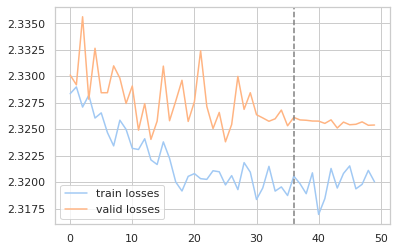

In [38]:
plt.plot(train_loss_NLL_hist,label="train losses")
plt.plot(valid_loss_NLL_hist,label="valid losses")
plt.axvline(best_epoch, color='gray',linestyle='--')
plt.legend()


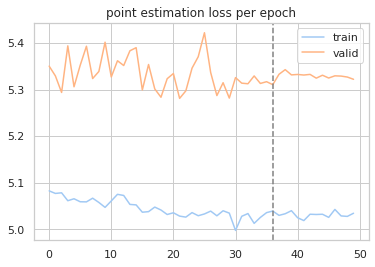

In [39]:
plt.plot(train_loss_est_hist,label="train")
plt.plot(valid_loss_est_hist,label="valid")
plt.axvline(best_epoch, color='gray',linestyle='--')

plt.title('point estimation loss per epoch')

plt.legend()

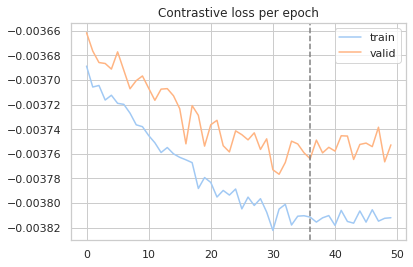

In [40]:
plt.plot(train_lost_ctr_hist,label="train")
plt.plot(valid_lost_ctr_hist,label="valid")
plt.title('Contrastive loss per epoch')
plt.axvline(best_epoch, color='gray',linestyle='--')

plt.legend()

In [15]:

'''covariate embedding'''
embedding = Embedding(ncov, cts_var, cts_idx, cat_var, cat_idx, x_landmarks, x_levels, m=args.s)

'''attention network'''
# attention = LinearAtt(ncov=ncov, dropout=0.1)
# attention = Attention(dropout=0.1)
attention = SelfAttention(dropout=0.1)
'''contrastive learning'''
# input is pair of latent Z
clf = FDV_CL(m = args.s, ncov = ncov, t_landmarks = t_landmarks, h_dim=args.enc_dim)


'''decoding the embedded vectors'''
decoder = DecMLP_bin(input_size = zdim, output_size = args.nbin, h_dim=args.dec_dim)


embedding.load_state_dict(torch.load(emb_path))
attention.load_state_dict(torch.load(att_path))
clf.load_state_dict(torch.load(clf_path))
decoder.load_state_dict(torch.load(dec_path))


# put models on device 0
embedding.to(device)
clf.to(device)
attention.to(device)
decoder.to(device)


decoder = nn.DataParallel(decoder, device_ids=device_ids)
attention = nn.DataParallel(attention, device_ids=device_ids)
clf = nn.DataParallel(clf, device_ids=device_ids)



In [16]:
# sns.barplot(np.arange(ncov),attention.weights.detach().cpu().numpy())
# plt.title('Linear Attention Weights')

In [17]:
embedding.x_emb_landmarks

ParameterDict(
    (AGE_DX): Parameter containing: [torch.cuda.FloatTensor of size 16x16 (GPU 0)]
    (HISTO2V): Parameter containing: [torch.cuda.FloatTensor of size 16x16 (GPU 0)]
    (HISTO3V): Parameter containing: [torch.cuda.FloatTensor of size 16x16 (GPU 0)]
    (EOD10_SZ): Parameter containing: [torch.cuda.FloatTensor of size 16x16 (GPU 0)]
    (EOD10_EX): Parameter containing: [torch.cuda.FloatTensor of size 16x16 (GPU 0)]
    (EOD10_ND): Parameter containing: [torch.cuda.FloatTensor of size 16x16 (GPU 0)]
    (EOD10_PN): Parameter containing: [torch.cuda.FloatTensor of size 16x16 (GPU 0)]
    (EOD10_NE): Parameter containing: [torch.cuda.FloatTensor of size 16x16 (GPU 0)]
    (CSTUMSIZ): Parameter containing: [torch.cuda.FloatTensor of size 16x16 (GPU 0)]
    (CSEXTEN): Parameter containing: [torch.cuda.FloatTensor of size 16x16 (GPU 0)]
    (CSLYMPHN): Parameter containing: [torch.cuda.FloatTensor of size 16x16 (GPU 0)]
    (CS3SITE): Parameter containing: [torch.cuda.FloatT

Text(0.5, 1.0, 'AGE embedding')

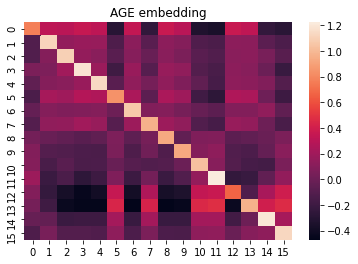

In [18]:
ax = sns.heatmap(embedding.x_emb_landmarks['AGE_DX'].detach().cpu().numpy())
plt.title('AGE embedding')

### Evaluating performance on testing dataset

In [44]:
from utils.metrics import NLL_reg, point_loss, get_CI_raw, pair_Ctd_DLN


embedding.eval()
decoder.eval()
clf.eval()
attention.eval()


test_e_loss = test_c_loss= 0
test_pred_t = []
test_pred_raw = []
test_t = []
test_e = []
# test_x = []
for i, (x, y, e, mask) in enumerate(t_pair1):
    x= x.to(device).float()
    y = y.to(device).float()
    e = e.to(device)
    mask = mask.to(device)
    
    x_emb, var_list = embedding(x.float())

    # re-indexing mask
    reindex = torch.tensor([np.where(cov_list==var)[0][0] for var in var_list]).to(device)
    mask_new = torch.index_select(mask, 1, reindex)
    del mask
    mask_attn = torch.ones(len(mask_new), ncov, ncov).to(device)-torch.diag(torch.ones(ncov)).unsqueeze(0).repeat(len(mask_new),1,1).to(device)+torch.vstack([torch.diag(mask_new[idx]).unsqueeze(0) for idx in range(len(mask_new))])
    del mask_new
    z, attn_score = attention(x_emb, mask = mask_attn)
    del mask_attn
 
    p_raw = decoder(clf.module.enc(z))

    loss_NLL = NLL_reg(p_raw, y, e, tt)

    # weighted average
    t_wa_hat = wt_avg(p_raw, tt)

    eloss, closs = point_loss(t_wa_hat, y, e, args.loss_type)
    loss_est = closs + eloss

    loss = loss_NLL + args.pt_wt*loss_est
    
#     test_x.append(x)
    test_pred_raw.append(p_raw.detach().cpu())
    test_pred_t.append(t_wa_hat.squeeze().detach().cpu())
    test_t.append(y.squeeze().detach().cpu())
    test_e.append(e.squeeze().detach().cpu())
    test_e_loss += eloss.item()

    test_c_loss += closs.item()

print(test_e_loss/len(test['e']))


586.5783093350899


In [45]:
test_pred_raw = torch.cat(test_pred_raw)
test_e = torch.cat(test_e)
test_t = torch.cat(test_t)
test_pred_t = torch.cat(test_pred_t)

Text(0.5, 1.0, 'Attention Score')

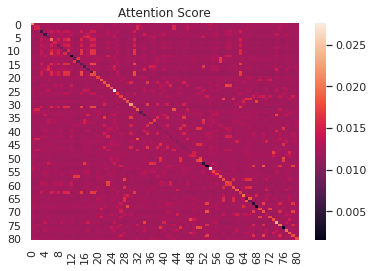

In [46]:
attn_score_avg = attn_score.mean(axis=0)
ax = sns.heatmap(attn_score_avg.detach().cpu().numpy())
plt.xticks_l = list(cov_list)
plt.title('Attention Score')

tensor(2.3234)

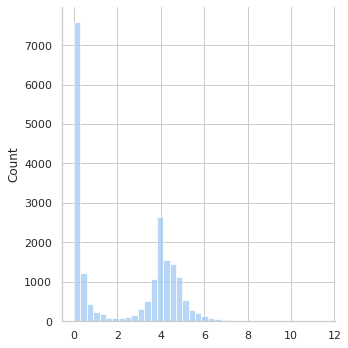

In [47]:

# test_x = torch.cat(test_x)
test_likeli = NLL_reg(test_pred_raw, test_t, test_e, tt, collapsed=False)
sns.displot(test_likeli.cpu().detach().numpy())
test_likeli.mean()


In [48]:
def I_Ctd_DLN(t, e, test_pred_prob, tt, i,j):
#     x_i = x[i]
#     x_j = x[j]
    t_true_i = t[i]
    t_i_idx = torch.where(batch_t_categorize(t[i].reshape([1,1]), e[i].reshape([1,1]), tt)[-1]==1)[0]
    sum_idx = torch.cat([torch.ones(t_i_idx), torch.zeros(len(tt)-t_i_idx)])
#     print(test_pred_prob[i], sum_idx)
    F_i = torch.dot(test_pred_prob[i].squeeze(), sum_idx)
    F_j = torch.dot(test_pred_prob[j].squeeze(), sum_idx)
    return(1*(F_i > F_j).cpu().detach().item())
    # return (log_S_i, log_S_j)

def pair_Ctd_DLN(t, e, test_pred_prob, tt):
    j_pool = []
    while len(j_pool)==0:
        subj_i = np.random.choice(torch.where(e==1)[0],1)
        j_pool = torch.where(t>t[subj_i])[0]
        
    subj_j = np.random.choice(torch.where(t>t[subj_i])[0],1)
        
    return(I_Ctd_DLN(t, e, test_pred_prob, tt, subj_i,subj_j))

In [49]:
ACSurv_Ctd = [pair_Ctd_DLN(test_t.to('cpu'), test_e.to('cpu'), test_pred_raw.to('cpu'), tt.to('cpu')) for k in np.arange(10000)]
np.mean(ACSurv_Ctd)

0.8296

0.8281349246452556

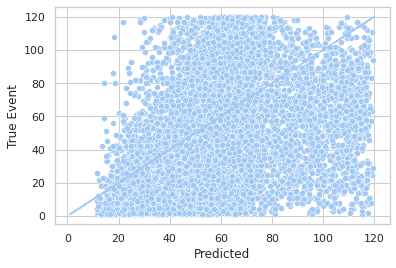

In [50]:

plt.figure()

sns.scatterplot(test_pred_t[test_e==1].cpu().detach().numpy().squeeze(), test_t[test_e==1].cpu())
plt.plot(test_t[test_e==1].cpu(), test_t[test_e==1].cpu())
plt.xlabel('Predicted')
plt.ylabel('True Event')

test_CI = get_CI_raw(test_e, test_t, test_pred_t, torch_object=True)[0]
test_CI


In [51]:
def calculate_quantiles(post_prob, tt, percentiles):
    post_prob_sum = np.cumsum(post_prob)
    try:
        tt_p = [tt[np.argmin(np.abs(post_prob_sum-p))] for p in percentiles]
    except TypeError:
        tt_p = tt[np.argmin(np.abs(post_prob_sum-percentiles))]
        tt_p = [tt_p]
        
    return(np.array(tt_p))


def calculate_coverage(pred_prob, tt, t_,quantiles, aft_model=False):
    if not aft_model:
        ci_list = [calculate_quantiles(post_prob,tt,quantiles) for post_prob in pred_prob]
        ci_list = np.array(ci_list)
    if aft_model:
        ci0 = aft.predict_percentile(pred_prob, p=quantiles[0]).values 
        ci1 = aft.predict_percentile(pred_prob, p=quantiles[1]).values
        ci_list = np.concatenate([ci1, ci0], axis=1)
        
    coverage_list = []
    for i in np.arange(len(t_)):
        if (t_[i]>=ci_list[i,0]) and (t_[i]<=ci_list[i,1]):
            coverage_list.append(1)            
        else:
            coverage_list.append(0)
    return(coverage_list)

def calculate_coverage_censor(pred_prob, tt, t_,quantiles, aft_model=False):
    if not aft_model:
        ci_list = [calculate_quantiles(post_prob,tt,quantiles) for post_prob in pred_prob]
        ci_list = np.array(ci_list)
    if aft_model:
        ci0 = aft.predict_percentile(pred_prob, p=quantiles).values 
        ci_list = np.array(ci0).reshape(len(t_))
    coverage_list = []
#     print(ci_list)
    for i in np.arange(len(t_)):
        if (t_[i]<=ci_list[i]):
            coverage_list.append(1)            
        else:
            coverage_list.append(0)
    return(coverage_list)

In [52]:
# from utils.metrics import calculate_coverage, calculate_coverage_censor

# load previous results
old_dir = '/data/zidi/cVAE/results/seer'

def loadResults(session_name, out_dir):
    test_pred_prob = np.load(out_dir+'/{}_test_pred_prob'.format(session_name)+'.npy')
    test_loglikeli = np.load(out_dir+'/{}_test_loglikeli'.format(session_name)+'.npy')
    return  test_pred_prob, test_loglikeli
VSI_pred_prob, VSI_loglikeli= loadResults('cVAE_q_seer', old_dir )
VSI_pred_medt = np.load(old_dir +'/{}_test_pred_medt'.format('cVAE_q_seer')+'.npy')
VSI_pred_avgt = np.load(old_dir +'/{}_test_pred_avgt'.format('cVAE_q_seer')+'.npy')
VSI_pred_randomt = np.load(old_dir +'/{}_test_pred_randomt'.format('cVAE_q_seer')+'.npy')
VSI_tt = np.load(old_dir +'/{}_tt'.format('cVAE_q_seer')+'.npy')

import pandas
result_dir = '/data/zidi/cVAE/results/seer/'
file_path = '/data/zidi/cVAE/datasets/'
VSI_tt = np.load(result_dir+'cVAE_q_seer_tt.npy')

VSI_test_t = np.load(file_path+'seer_test_t.npy')
VSI_test_e = np.load(file_path+'seer_test_e.npy')
VSI_test = {'t':VSI_test_t, 'e':VSI_test_e}

del VSI_test_t,VSI_test_e


Text(0.5, 1.0, 'covarage rate for censoring\nSEER Dataset')

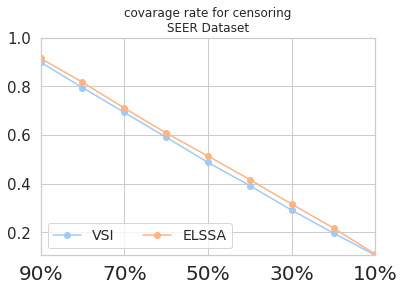

In [53]:
quantile_list = np.delete(np.linspace(0,0.5,10, endpoint=False),0)
quantiles_list = [[q, 1.-q]for q in quantile_list]
select_idx = (test_e.numpy()==1)
model_coverage =  [np.mean(calculate_coverage(test_pred_raw[select_idx].numpy(), tt.detach().cpu().numpy(), test_t[select_idx].numpy(),quantiles=q)) for q in quantiles_list]

select_idx = VSI_test['e']==1
VSI_coverage =  [np.mean(calculate_coverage(VSI_pred_prob[select_idx], VSI_tt, VSI_test['t'][select_idx],quantiles=q)) for q in quantiles_list]
# RSF_coverage =  [np.mean(calculate_coverage(RSF_pred_prob[select_idx], tt, test['t'][select_idx],quantiles=q)) for q in quantiles_list]

sns.set(style="whitegrid", palette="pastel", color_codes=True)


plt.plot(VSI_coverage, '-o', label = 'VSI')
plt.plot(model_coverage, '-o', label = 'ELSSA')

# plt.plot(RSF_coverage, label = 'RSF', color = RSFcolor)


# plt.xticks([0.5,4,7.5],['[0.05,0.95]', '[0.25,0.75]', '[0.45,0.55]'],size=20, rotation=0)#, rotation=25)
# plt.yticks([0.2,0.4,0.6,0.8],size=15)#, rotation=25)

plt.margins(0,0)
plt.legend(prop={'size': 14},ncol=2,loc='lower right')

plt.xticks([0,2,4,6,8],['90%', '70%', '50%', '30%','10%'],size=20, rotation=0)#, rotation=25)
plt.yticks([0.2,0.4,0.6,0.8,1.0],size=15)#, rotation=25)

plt.legend(prop={'size': 14},ncol=2,loc='lower left')

plt.title('covarage rate for censoring\n'+'SEER Dataset')


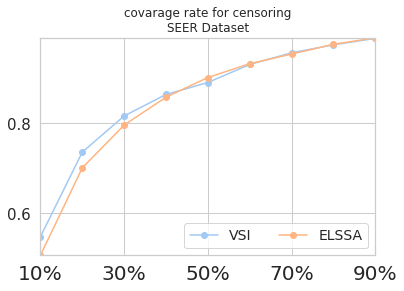

In [54]:
sns.set(style="whitegrid", palette="pastel", color_codes=True)

quantiles_list = np.delete(np.linspace(0,1.0,10, endpoint=False),0)

select_idx = (VSI_test['e']==0)
VSI_coverage =  [np.mean(calculate_coverage_censor(VSI_pred_prob[select_idx], VSI_tt, VSI_test['t'][select_idx],quantiles=q)) for q in quantiles_list]
# RSF_coverage =  [np.mean(calculate_coverage_censor(RSF_pred_prob[select_idx], tt, test['t'][select_idx],quantiles=q)) for q in quantiles_list]

select_idx = (test_e.numpy()==0)
model_coverage =  [np.mean(calculate_coverage_censor(test_pred_raw[select_idx].numpy(), tt.detach().cpu().numpy(), test_t[select_idx].numpy(),quantiles=q)) for q in quantiles_list]



plt.plot(VSI_coverage, '-o', label = 'VSI')
plt.plot(model_coverage, '-o', label = 'ELSSA')

range_list = [ "[" + str(np.round(q,2))+', 1.0]' for q in quantiles_list]


plt.margins(0,0)
plt.legend(prop={'size': 14},ncol=2,loc='lower right')

plt.xticks([0,2,4,6,8],['10%', '30%', '50%', '70%','90%'],size=20, rotation=0)#, rotation=25)
plt.yticks([0.2,0.4, 0.6,0.8,1.0],size=15)#, rotation=25)


# plt.ylabel('coverage')
# plt.xlabel('quantiles range')
plt.title('covarage rate for censoring\n'+'SEER Dataset')
plt.margins(0,0)# plt.savefig(fig_path+'/flchain_c_coverage.pdf', bbox_inches='tight')